In [1]:
import os
import pandas as pd
import scipy as sp
from scipy import stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def ajuste_mcp(serie_real,serie_std):
     
    m1=serie_real["IDEAM"].mean()
    m2=serie_std["NREL"].mean()
    d1=serie_real["IDEAM"].std(ddof=0)
    d2=serie_std["NREL"].std(ddof=0)
    GHImcp= pd.DataFrame(((m1-(d1/d2)*m2)+(d1/d2)*serie_std["NREL"]))
    GHImcp[GHImcp<0]=0
    serie_ajustada=serie_std.copy()
    del serie_ajustada['NREL']
    serie_ajustada['GHIdiario']=GHImcp
    return (serie_ajustada)

In [4]:
def ENFICC(serie):
    
    def ghi_mensual(serie_horaria):
        agnos = sorted(serie_horaria['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
        for agno in range(2006,2016):
            for mes in range(1,13):
                nombre_energia = list(serie_horaria)[-1]
                dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) &
                            (serie_horaria['MES'] == mes)]["DIA"].unique())
                ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                                & (serie_horaria["MES"] == mes)),
                                            nombre_energia].sum()/1000
                ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1],
                            "GHImes":ghi_mes}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df
    
    def ghi_dia(serie_ghi_mensual):
        agnos = sorted(serie_ghi_mensual['AÑO'].unique())
        ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
        for agno in range(2006,2016):
            for mes in range(1,13):
                dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)
                                & (serie_ghi_mensual["MES"] == mes))
                                             ,"DIAS"].item()
                ghi_diario = serie_ghi_mensual.loc[(
                    (serie_ghi_mensual["AÑO"] == agno)
                                & (serie_ghi_mensual["MES"] == mes)),
                    "GHImes"].item()/dias
                ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
                ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
        return ghi_df

    ghi_mensual_loc = ghi_mensual(serie)
    ghi_dia_loc=ghi_dia(ghi_mensual_loc)
    datos = sorted(ghi_dia_loc["GHIdiario"])
    numdatos = range(len(datos))
    percentil = 0.01
    enficc = ghi_dia_loc.quantile(q=percentil, 
                                 numeric_only=True)["GHIdiario"]
    print('La ENFICC 99% es: ',enficc)
    return enficc,datos,numdatos

In [5]:
def grafica(enficc_real,enficc_satel,enficc_mcp):
    pylab.xlabel("Datos")
    pylab.ylabel("Energía")
    pylab.plot(enficc_real[2],enficc_real[1]/(enficc_real[1])[0],label='IDEAM')
    pylab.plot(enficc_satel[2],enficc_satel[1]/(enficc_real[1])[0],label='NREL')
    pylab.plot(enficc_mcp[2],enficc_mcp[1]/(enficc_real[1])[0],label='NREL AJUSTADA')
    pylab.legend(loc='upper left')
    return 

In [6]:
def errores(real,mcp):
    dfreal=pd.DataFrame(real,columns=["datos"])
    dfmcp=pd.DataFrame(mcp,columns=["datos"])
    rmsen=(np.sqrt(((dfreal - dfmcp) ** 2).mean()))/(dfreal["datos"].iloc[-1]-dfreal["datos"].iloc[0])
    mbe=(dfmcp-dfreal).sum()/dfmcp.sum()
    KSI=sp.stats.ks_2samp(real,mcp)
    print('El RMSEn es: ',rmsen)
    print('El MBE es: ',mbe)
    print('El p de KSI es: ',KSI[1])
    return

In [7]:
base_dir = os.path.join( '.','data')
output_dir = os.path.join( '.','output')
ciudad = 'Valledupar'
fuente1 = 'IDEAM'
fuente2= 'NREL'
serie_csv1 = os.path.join(base_dir,ciudad,fuente1+'.csv')
serie_csv2 = os.path.join(base_dir,ciudad,fuente2+'.csv')
serie_real = pd.read_csv(serie_csv1, sep = ';',
                encoding='latin-1')
serie_satel = pd.read_csv(serie_csv2, sep = ';',
                encoding='latin-1')

In [13]:
serie_rec1=serie_real.loc[(serie_real["MES"]==1)&(serie_real["AÑO"]==2006)]

In [14]:
ajuste= ajuste_mcp(serie_rec1,serie_satel)

In [15]:
enficc_real=ENFICC(serie_real)
enficc_satel=ENFICC(serie_satel)
enficc_mcp=ENFICC(ajuste)

La ENFICC 99% es:  4.56900737661
La ENFICC 99% es:  5.06672598387
La ENFICC 99% es:  4.60325217207


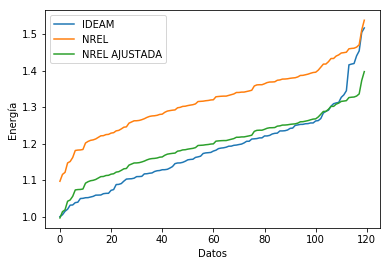

In [16]:
grafica(enficc_real,enficc_satel,enficc_mcp)

In [17]:
errores(enficc_real[1],enficc_mcp[1])

El RMSEn es:  datos    0.072608
dtype: float64
El MBE es:  datos    0.012927
dtype: float64
El p de KSI es:  0.122279187014
